<a href="https://colab.research.google.com/github/Venusandjupiter/MachineLearning/blob/main/CNN/GoogLeNet/GoogLeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import dataloader
import train
from torch import nn
import GoogLeNet
import torch
import torchinfo
import matplotlib.pyplot as plt
import torchvision
import random


Block1 = nn.Sequential(
    nn.Conv2d(in_channels=3,out_channels=64,kernel_size=(7,7),stride=2,padding=3),nn.ReLU(),
    nn.MaxPool2d(kernel_size=(3,3),stride=2,padding=1)
)

Block2 = nn.Sequential(
    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(1,1)),nn.ReLU(),
    nn.Conv2d(in_channels=64,out_channels=192,kernel_size=(3,3),padding=1),nn.ReLU(),
    nn.MaxPool2d(kernel_size=(3,3),stride=2,padding=1)
)

Block3 = nn.Sequential(
    GoogLeNet.Inception(in_channels=192,path1=64,path2=(96,128),path3=(16,32),path4=32),
    GoogLeNet.Inception(in_channels=256,path1=128,path2=(128,192),path3=(32,96),path4=64),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
)

Block4 = nn.Sequential(
    GoogLeNet.Inception(480, 192, (96, 208), (16, 48), 64),
    GoogLeNet.Inception(512, 160, (112, 224), (24, 64), 64),
    GoogLeNet.Inception(512, 128, (128, 256), (24, 64), 64),
    GoogLeNet.Inception(512, 112, (144, 288), (32, 64), 64),
    GoogLeNet.Inception(528, 256, (160, 320), (32, 128), 128),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)


Block5 = nn.Sequential(
    GoogLeNet.Inception(832, 256, (160, 320), (32, 128), 128),
    GoogLeNet.Inception(832, 384, (192, 384), (48, 128), 128),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten())

Model = nn.Sequential(Block1,Block2,Block3,Block4,Block5,nn.Dropout(0.3),nn.Linear(1024,10))

In [3]:
Device = 'cuda' if torch.cuda.is_available() else 'cpu'
path = './dataset'
torchinfo.summary(Model,[1,3,96,96])

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 24, 24]           --
│    └─Conv2d: 2-1                       [1, 64, 48, 48]           9,472
│    └─ReLU: 2-2                         [1, 64, 48, 48]           --
│    └─MaxPool2d: 2-3                    [1, 64, 24, 24]           --
├─Sequential: 1-2                        [1, 192, 12, 12]          --
│    └─Conv2d: 2-4                       [1, 64, 24, 24]           4,160
│    └─ReLU: 2-5                         [1, 64, 24, 24]           --
│    └─Conv2d: 2-6                       [1, 192, 24, 24]          110,784
│    └─ReLU: 2-7                         [1, 192, 24, 24]          --
│    └─MaxPool2d: 2-8                    [1, 192, 12, 12]          --
├─Sequential: 1-3                        [1, 480, 6, 6]            --
│    └─Inception: 2-9                    [1, 256, 12, 12]          --
│   

In [4]:
train_data = dataloader.GetCIFAR10(path,train=True,download=True)
val_data = dataloader.GetCIFAR10(path,train=False,download=True)
train_iter = dataloader.iter_transform(dataset=train_data,batch_size=512,shuffle=True)
val_iter = dataloader.iter_transform(dataset=val_data,batch_size=512,shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
!nvidia-smi

Thu Jan 26 14:39:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    32W /  70W |   1098MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Running on: Tesla T4
=============================epochs:1========================================
train loss:2.126,train acc:18.46%, val_acc:26.92%
=============================epochs:2========================================
train loss:1.861,train acc:29.68%, val_acc:37.34%
=============================epochs:3========================================
train loss:1.566,train acc:41.26%, val_acc:43.93%
=============================epochs:4========================================
train loss:1.385,train acc:48.67%, val_acc:54.40%
=============================epochs:5========================================
train loss:1.222,train acc:55.25%, val_acc:56.78%
=============================epochs:6========================================
train loss:1.084,train acc:60.67%, val_acc:61.33%
=============================epochs:7========================================
train loss:0.966,train acc:65.23%, val_acc:64.47%
=============================epochs:8========================================
train

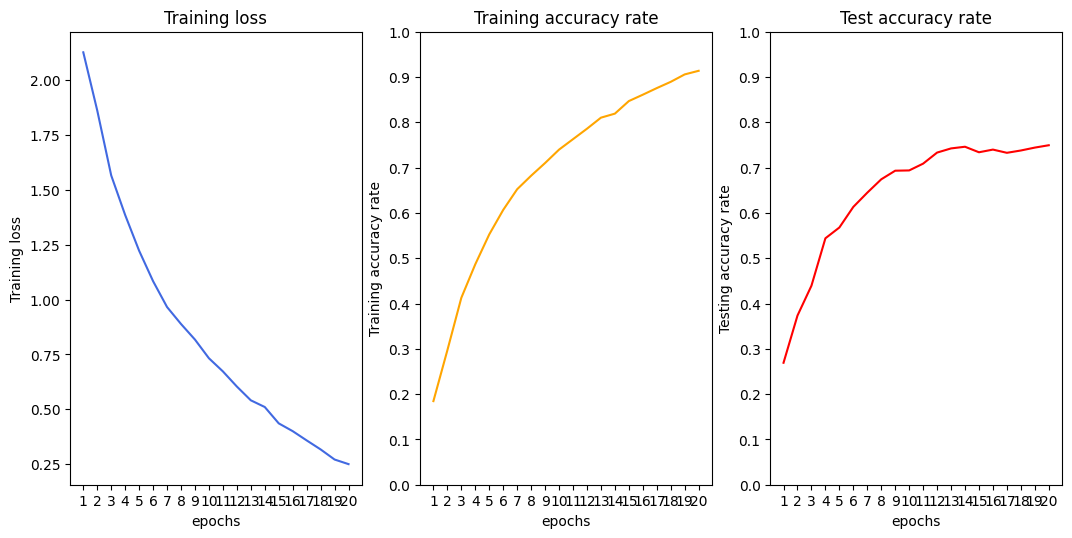

In [17]:
loss_fn = nn.CrossEntropyLoss()
train.train_loop(net=Model,loss_fn=loss_fn,num_epochs=20,learning_rate=1e-3,train_iter=train_iter,val_iter=val_iter,device=Device)

In [15]:
def predict(dataset,net):
    to_img = torchvision.transforms.ToPILImage()
    net.eval()
    net.to('cpu')
    imgs_index = []
    imgs = []
    pred_labels = []
    accuracy = 0.0
    labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
    for i in range(20):
        imgs_index.append(random.randint(0,10000))
    for item in imgs_index:
        pred_labels.append(torch.argmax(net(dataset[item][0].reshape(1,3,96,96)),dim=1).item())
        imgs.append((to_img(dataset[item][0]),dataset[item][1]))
    fig, axs = plt.subplots(2, 10, figsize=(21, 5), dpi=100)
    for i in range(axs.shape[0]):
        for j in range(axs.shape[1]):
            axs[i][j].imshow(imgs[i*10+j][0])
            if pred_labels[i*10+j] == imgs[i*10+j][1]:
                axs[i][j].set_title(labels[pred_labels[i*10+j]])
                accuracy += 1
            else:
                axs[i][j].set_title(labels[pred_labels[i*10+j]],color='orange')
    print(f'accuracy rate:{round(accuracy/20*100,4)}%')

accuracy rate:90.0%


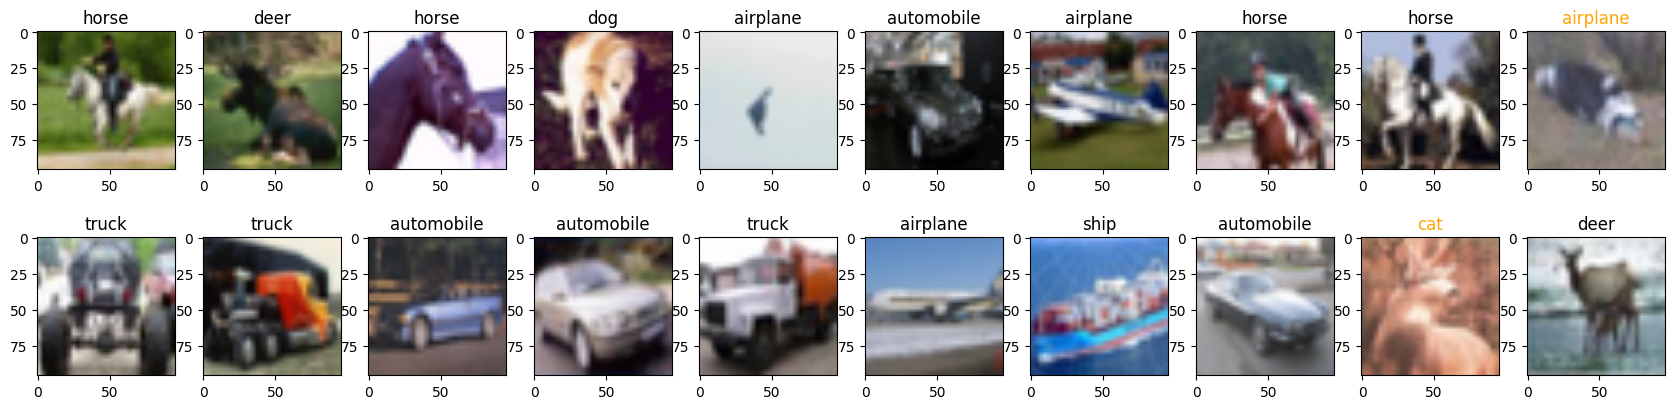

In [22]:
predict(val_data,Model)

In [21]:
torch.save(Model.to('cpu'),'./GoogLeNet.pt')